# Eco-evolutionary dynamics in consumer-resource models
Zhijie Feng

Here we use constraint optimization mapping to simualte invasion in consumer-resource models. There are several model choises we can make. Here we allow two types of resource dynamics: MacArthur or linear. And we can choose wherther we allow resource to extinct (permanently), and whether new resource invade simultaneously with consumers.
## Models
MacArthur Consumer-Resource Model
\begin{align*}
    \frac{dX_i}{dt} &= X_i (\sum_\alpha c_{i\alpha} R_\alpha - m_i) \\
    \frac{dR_{\alpha}}{dt} &= R_{\alpha}( k_{\alpha} - R_{\alpha} - \sum_j c_{j \alpha} X_j)
\end{align*}

Linear resource dynamics Consumer-Resource Model
\begin{align*}
    \frac{dX_i}{dt} &= X_i (\sum_\alpha c_{i\alpha} R_\alpha - m_i) \\
    \frac{dR_{\alpha}}{dt} &= k_{\alpha} - R_{\alpha} - \sum_j c_{j \alpha} X_jR_{\alpha}
\end{align*}

In [16]:
from scipy.integrate import solve_ivp
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns 
import cvxpy as cvx
from scipy import stats
import time
import pickle
from collections import  defaultdict

In [17]:
cd /Users/zhijie/Documents/GitHub/eco-evolution-simulator

/Users/zhijie/Documents/GitHub/eco-evolution-simulator


In [18]:
from IPython.display import Image


## Invasion dynamics simulation
Here we construct the class TrajectorySimulator to simulate one invasion trajectory with given input parameters. For each step of the trajectory, a indaver is generated, and invade the ecologically stable ecosystem. Since successful invasion is possible only if invader's immediate growth rate is positive, we check it to reduce computation time. We update the ecosystem by computing the new steady state with the invader added.


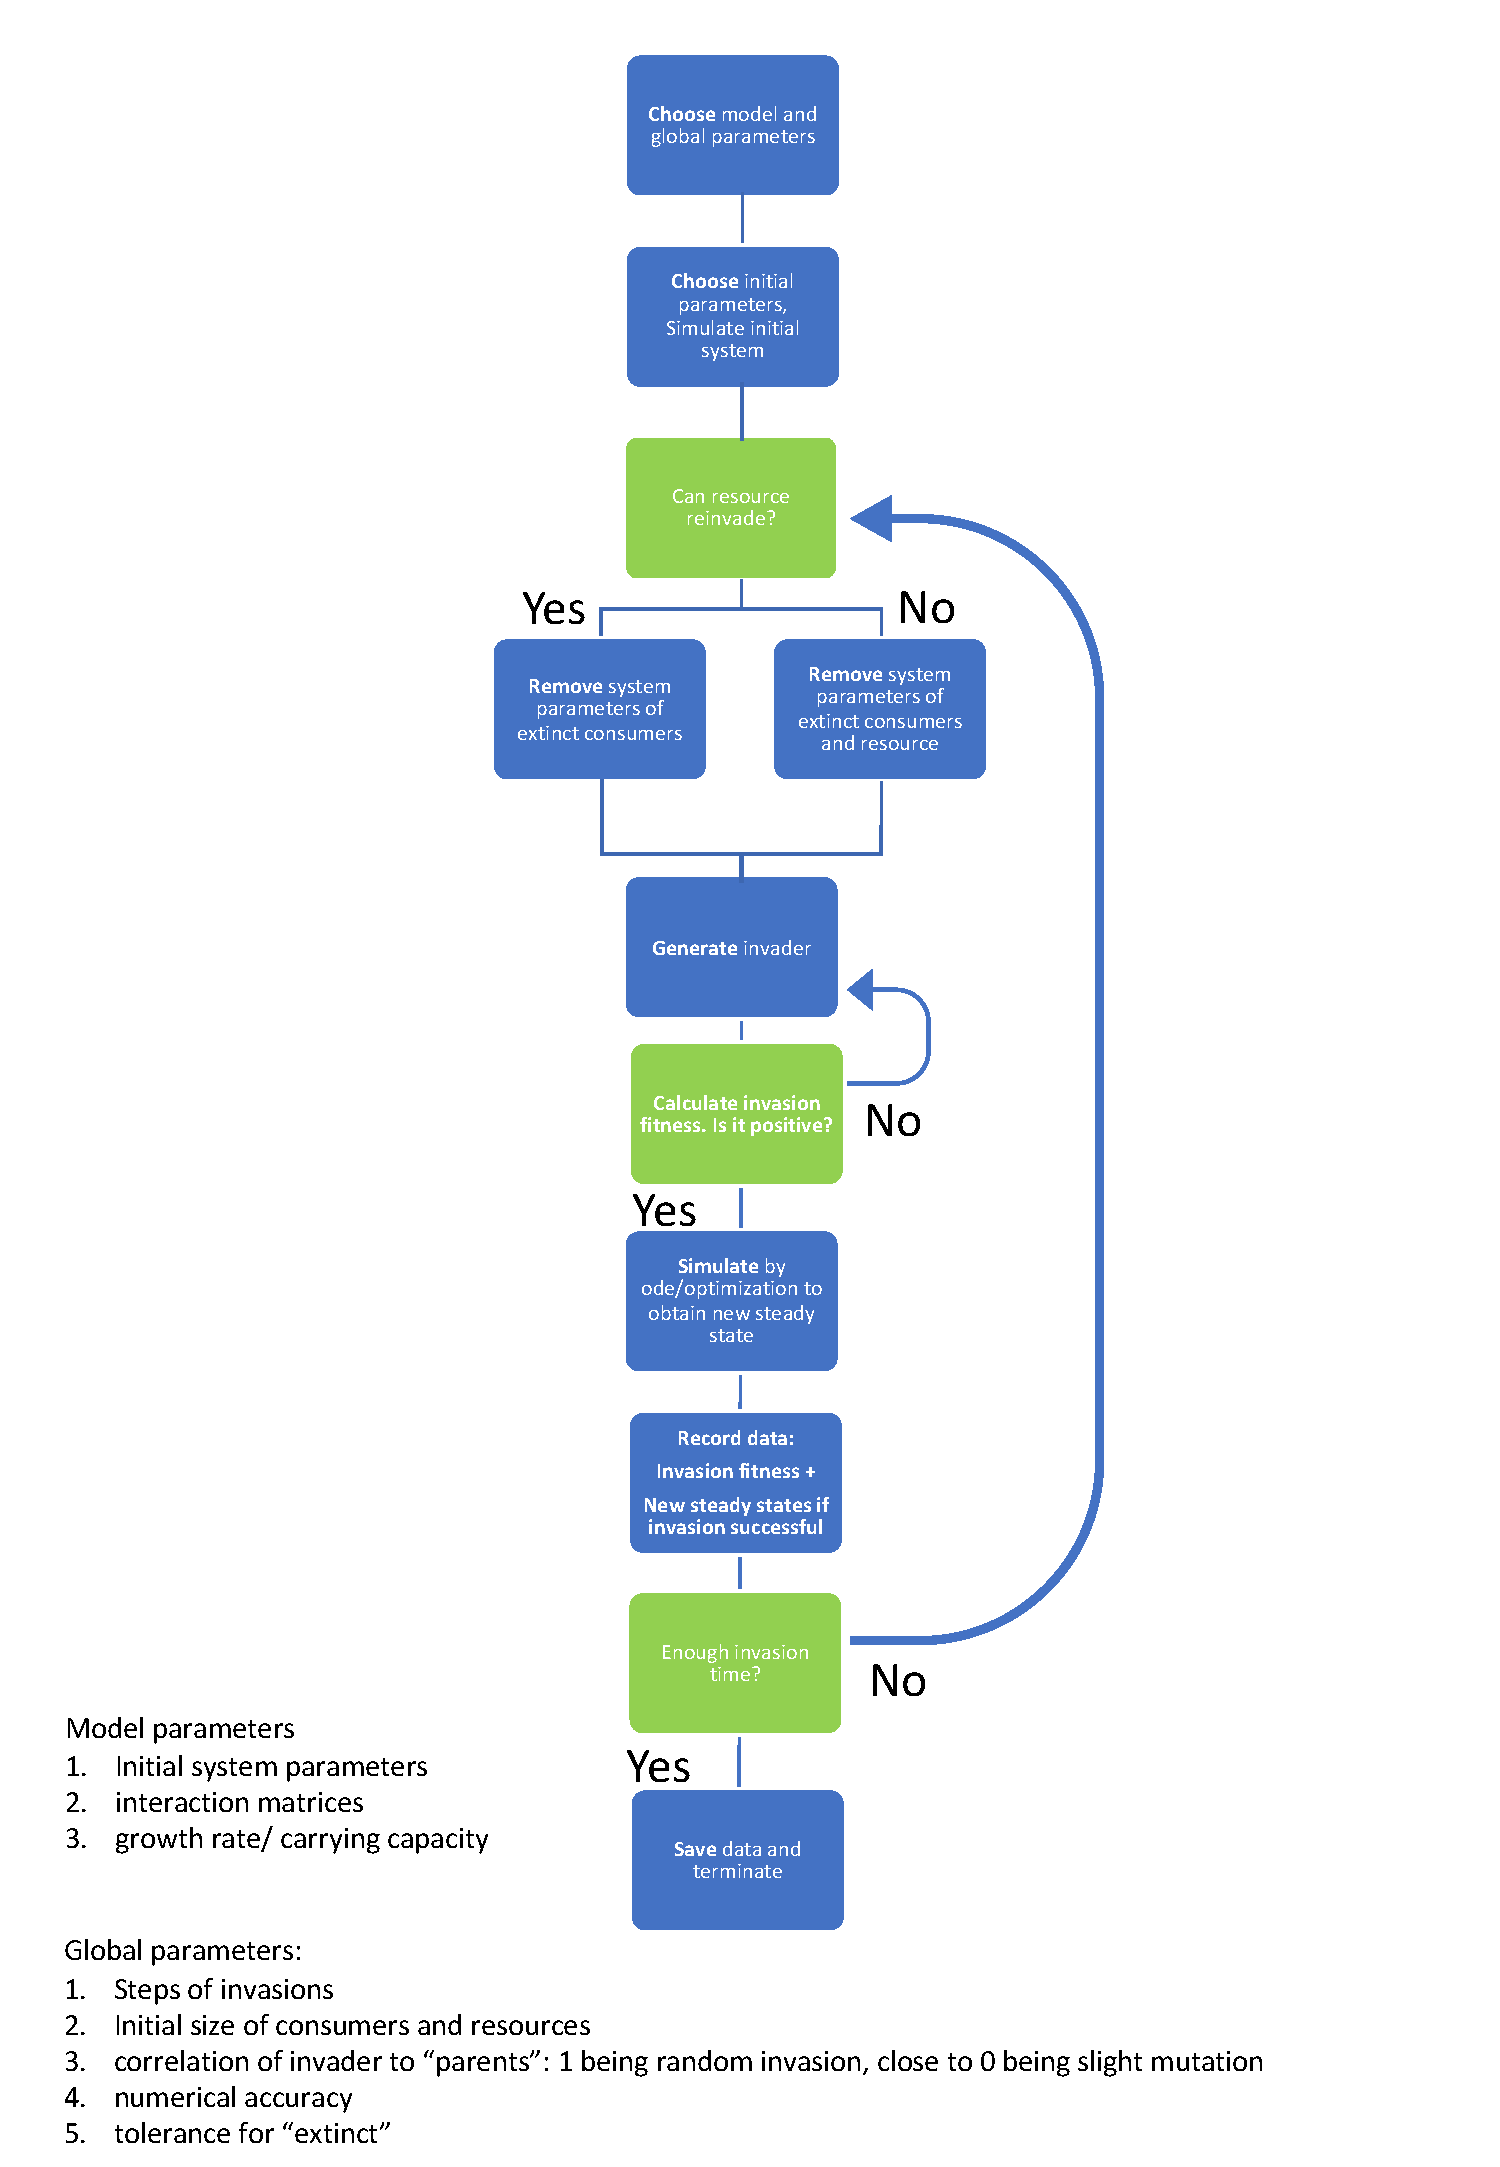

In [19]:
Image("flowchart.png")


In [28]:
class TrajectorySimulator:
    def __init__(self, input_params):
        # Initialize the simulation parameters
        self.top_species = input_params['top_species']
        self.resources = input_params['resources']
        self.meank = input_params['meank']
        self.total_invasion = input_params['total_invasion']
        self.resource_dynamics = input_params['resource_dynamics']
        self.resource_extinct = input_params['resource_extinct']
        self.resource_invade = input_params['resource_invade']
        self.mutation_weight = input_params['mutation_weight']
        self.C_mean = 1
        self.C_std_dev = 1

        # Initialize data storage for simulation results by defaultdict which automatically initialize dictionary with empty lists
        self.results=defaultdict(list) 
        
        '''
            'successful_index': [], #the invasion times that sucessful invasion happened
            'List_packing': [], #the ratio of number of surviving consumers over number of surviving consumers
            'List_meanfitness': [], #the system average of CK-m
            'List_N': [], # each data is a list of consumer abundance for each species that survive in the last step, plus final element being the invader  
            'List_R': [], # each data is a list of resource abundance for each resources that survive in the last step, plus final element being the invader  
            'List_surviveN': [], # each data is a list of boolean variable, being 1 means the consumer is recognized as survived
            'List_surviveR': [], # each data is a list of boolean variable, being 1 means the resource is recognized as survived
            'List_invasion_fitness': [] # invasion fitness of all invasions
        '''
        
       
    def initialize_parameters(self):
        # Initialize the consumer and resource matrices and vectors
        self.C = self.C_mean / self.resources + self.C_std_dev * np.random.normal(0, 1, (self.top_species, self.resources)) / np.sqrt(self.resources)
        self.m = np.ones(self.top_species)
        self.k = np.ones(self.resources) * self.meank

    def record_results(self, invasion, N_opt_value, R_opt_value, top_survived, resources_survived,List_invasion_fitness):
        # Record simulation results for the given invasion
        self.results['successful_index'].append(invasion)
        self.results['List_packing'].append(sum(top_survived) / sum(resources_survived))
        self.results['List_meanfitness'].append(np.mean(self.C @ self.k - self.m))
        self.results['List_N'].append(N_opt_value)
        self.results['List_R'].append(R_opt_value)
        self.results['List_surviveN'].append(top_survived)
        self.results['List_surviveR'].append(resources_survived)
        self.results['List_invasion_fitness']+=List_invasion_fitness # concatenate invasion fitness for all attempted invasions

    def invade(self, R_opt_value, resources_survived, invasionC, invasionm):
        # Add invading species into the model
        self.C, self.m = np.concatenate((self.C, invasionC)), np.concatenate((self.m, invasionm))
        if self.resource_invade:
            invasionR, invasionk = self.C_mean / self.resources + self.C_std_dev * np.random.normal(0, 1, (len(self.C), 1)) / np.sqrt(self.resources), [self.meank]
            self.C, self.k = np.concatenate((self.C, invasionR), axis=1), np.concatenate((self.k, invasionk))

    def extinction(self, top_survived, resources_survived):
        # Handle species extinction in the model
        if self.resource_extinct:
            self.C, self.m, self.k = self.C[top_survived, :][:, resources_survived], self.m[top_survived], self.k[resources_survived]
        else:
            self.C, self.m = self.C[top_survived, :], self.m[top_survived]
            
    def steady_state(self):
        # Calculate the steady-state of the model
        R_opt = cvx.Variable(len(self.k))
        if self.resource_dynamics == 'MCRM':
            constraints = [self.C @ R_opt <= self.m, R_opt >= 0]
            prob = cvx.Problem(cvx.Minimize(0.5 * cvx.sum_squares(R_opt - self.k)), constraints)
            prob_output = prob.solve(solver=cvx.OSQP, eps_abs=1e-7, eps_rel=1e-7, max_iter=100000, warm_start=True, verbose=False)
        elif self.resource_dynamics == 'linear':
            constraints = [self.C @ R_opt <= self.m]
            prob = cvx.Problem(cvx.Minimize(cvx.sum(cvx.kl_div(self.k + 1e-9, R_opt + 1e-9)), constraints))
            prob_output = prob.solve(solver=cvx.ECOS, abstol=1e-7, reltol=1e-7, warm_start=True, verbose=False, max_iter=100000)
        return  prob.constraints[0].dual_value, R_opt.value

    def mutation(self, parent, mutate):
        # Apply mutation to a species
        return self.mutation_weight * mutate + (1 - self.mutation_weight) * parent
    
    def get_invasion_fitness(self, invasionC, invasionm, R_opt_value, resources_survived):
        invasion_fitness = invasionC @ R_opt_value[resources_survived] - invasionm if self.resource_extinct else invasionC @ R_opt_value - invasionm
        if len(invasion_fitness)>1:print("invasion fitness error")
        return invasion_fitness[0]
    
    def run_simulation(self):
        self.initialize_parameters()
        
        List_invasion_fitness = []
        invadebool, old_N_opt_value = True, np.zeros(1)
                        
        for invasion in range(self.total_invasion):
            if invadebool:
               
                N_opt_value, R_opt_value = self.steady_state()
                
                top_survived, resources_survived = N_opt_value > 1e-5, R_opt_value > 1e-5
                
                if sum(top_survived) > 0:#only remove extinct consumer when it is not the only consumer 
                    self.extinction(top_survived, resources_survived) 
                    
                if not np.array_equal(N_opt_value, old_N_opt_value):
                    # Only record when invasion is successful
                    old_N_opt_value = N_opt_value
                    self.record_results(invasion, N_opt_value, R_opt_value, top_survived, resources_survived, List_invasion_fitness)
                    
            invasionC, invasionm = self.C_mean / self.resources + self.C_std_dev * np.random.normal(0, 1, (1, max(sum(resources_survived), np.shape(self.C)[-1]))) / np.sqrt(self.resources), np.array([1])
           
            if self.mutation_weight > 0:
                parent_index = np.random.randint(len(self.C))
                invasionC, invasionm = self.mutation(np.array([self.C[parent_index]]), invasionC), self.mutation(np.array([self.m[parent_index]]), invasionm)
                
            #invasion_fitness = invasionC @ R_opt_value[resources_survived] - invasionm if self.resource_extinct else invasionC @ R_opt_value - invasionm
            invasion_fitness = self.get_invasion_fitness(invasionC, invasionm, R_opt_value, resources_survived)
            List_invasion_fitness.append(invasion_fitness)

            if not self.resource_invade:
                invadebool = invasion_fitness > 0 #invasion only possible when immediate growth rate is positive

            if invadebool:
                self.invade(R_opt_value, resources_survived, invasionC, invasionm)

        return self.results

#Here is an easy example to check if the simulation is working
if __name__ == '__main__':
    input_params = {
        'top_species': 1, # initial number of species of consumers
        'resources': 30, # initial number of species of resources
        'meank': 3, #mean value of k
        'total_invasion': 1000, #total number of invasion steps
        'resource_dynamics': 'MCRM', #type of resource dynamics in the model, it can be 'MCRR' or 'linear'
        'resource_extinct': False, # whether we remove resource permenantly if it extinct in one invasion step
        'resource_invade': False, # whether we simultaneously let a random resource invade
        'mutation_weight': 0.01 # correlation of invader to “parents”: 1 being random invasion, ->0 being slight mutation
    
    }
    
    start_time = time.time()
    simulator = TrajectorySimulator(input_params)
    oneresult = simulator.run_simulation()
    
    print("--- %s seconds ---" % (time.time() - start_time))


--- 2.5921058654785156 seconds ---


## Iteration
We construct functions to iterate any number of parameters over specified ranges, with parrllel computing. And we save the result with pickle.

In [6]:

from joblib import Parallel, delayed

def run_simulation(input_params):
    # Create a TrajectorySimulator instance
    simulator = TrajectorySimulator(input_params)

    # Run the simulation for the given input parameters
    result = simulator.run_simulation()

    return result

def iterate_over_parameter_ranges(parameter_ranges, common_input_params):
    results_dict = {}

    # Create a list of dictionaries representing all combinations of parameter values
    param_combinations = []

    for param1_value in parameter_ranges[0]['values']:
        for param2_value in parameter_ranges[1]['values']:
            input_params = {
                **common_input_params,  # Use the common parameters
                parameter_ranges[0]['param_name']: param1_value,
                parameter_ranges[1]['param_name']: param2_value
            }
            param_combinations.append(input_params)

    # Use joblib to parallelize the execution of simulations
    results = Parallel(n_jobs=-1)(delayed(run_simulation)(input_params) for input_params in param_combinations)

    # Iterate over all parameter combinations and store the results
    for i, input_params in enumerate(param_combinations):
        result = results[i]

        # Create a key that combines both parameter values
        param_key = f"{parameter_ranges[0]['param_name']}={input_params[parameter_ranges[0]['param_name']]}_" \
                    f"{parameter_ranges[1]['param_name']}={input_params[parameter_ranges[1]['param_name']]}"

        # Store the results in the dictionary with the combined parameter key
        results_dict[param_key] = result

    # Save the results to a file using pickle
    with open('simulation_results.pkl', 'wb') as file:
        pickle.dump(results_dict, file)
start_time = time.time()

if __name__ == '__main__':
    # Define parameter ranges for meank and meanm
    parameter_ranges = [
        {
            'param_name': 'meank',
            'values': [5, 10, 15]
        },
        {
            'param_name': 'mutation_weight',
            'values': [0.01, 0.1, 1.0]
        }
        
        # Add more parameter ranges as needed
    ]

    # Common input parameters
    common_input_params = {
        'top_species': 3,
        'resources': 30,
        'C_mean': 1,
        'C_std_dev': 0.1,
        'total_invasion': 10000,
        'resource_dynamics': 'MCRM',
        'resource_extinct': False,
        'resource_invade': False,
        'mutation_weight': 0.01,
        'meanm':1
    }

    # Call the function to iterate over parameter ranges and run simulations
    iterate_over_parameter_ranges(parameter_ranges, common_input_params)
print("--- %s seconds ---" % (time.time() - start_time))

--- 34.395665884017944 seconds ---


# Visualization
Here we visualize the result we collected from the simulations

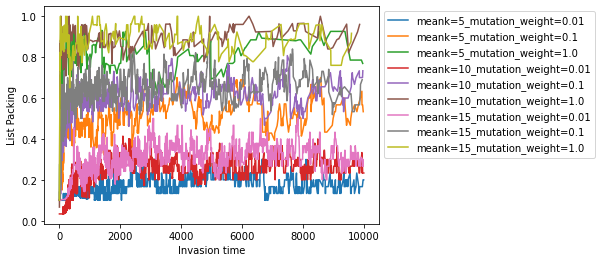

In [7]:
def load_results(filename):
    with open(filename, 'rb') as file:
        results_dict = pickle.load(file)
    return results_dict

def plot_2d_results(results_dict, x_data, y_data, x_label, y_label, xscale='linear', yscale='linear'):
    for param_key, result in results_dict.items():
        x_values = result[x_data]
        y_values = result[y_data]
        plt.plot(x_values, y_values, label=param_key,)

    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.yscale(yscale) 
    plt.xscale(xscale) 
    
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()

if __name__ == '__main__':
    # Load the saved results
    filename = 'simulation_results.pkl'
    results_dict = load_results(filename)

    # Specify the x and y data, and their labels
    x_data = 'successful_index'
    y_data = 'List_packing'
    x_label = 'Invasion time'
    y_label = 'List Packing'

    # Plot the 2D results with legends for parameter values
    plot_2d_results(results_dict, x_data, y_data, x_label, y_label)


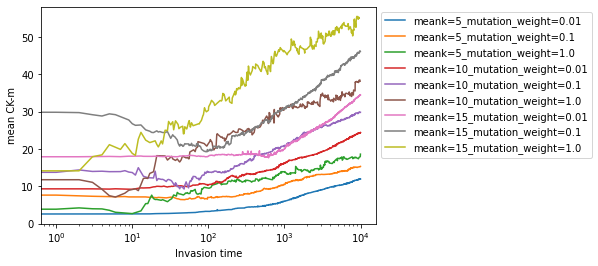

In [8]:
x_data = 'successful_index'
y_data = 'List_meanfitness'
x_label = 'Invasion time'
y_label = 'mean CK-m'

# Plot the 2D results with legends for parameter values
plot_2d_results(results_dict, x_data, y_data, x_label, y_label,xscale='log')
